In [738]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import string
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import make_pipeline

In [20]:
df_train = pd.read_csv('train.csv', names = ['genre', 'text'], delimiter=';')

In [21]:
df_train.shape

(9245, 2)

In [22]:
df_train.shape

(9245, 2)

In [23]:
df_train.head()

,genre,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"'Erfundene Bilder zu Filmen, die als verloren ..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


In [76]:
df_train.isna().sum()

genre    0
text     0
dtype: int64

In [25]:
df_train.genre.value_counts()

Panorama         1510
Web              1509
International    1360
Wirtschaft       1270
Sport            1081
Inland            913
Etat              601
Wissenschaft      516
Kultur            485
Name: genre, dtype: int64

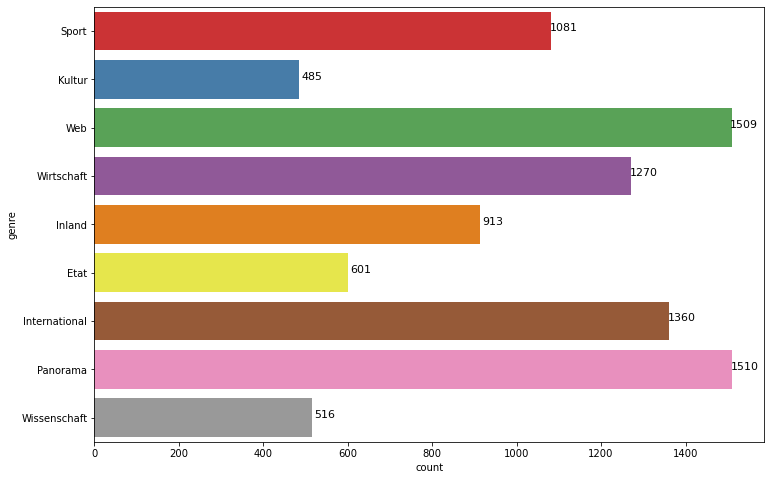

In [75]:
plt.figure(figsize=(12,8))
ax = sns.countplot(y='genre', data=df_train, palette='Set1')
for rect in ax.patches:
    ax.text(rect.get_width()+ 30.0, rect.get_y() + rect.get_height()/ 2, rect.get_width(), horizontalalignment='center', fontsize = 11)
plt.show()

In [91]:
df_train['text_length'] = df_train.text.str.len()

<AxesSubplot:xlabel='text_length', ylabel='Count'>

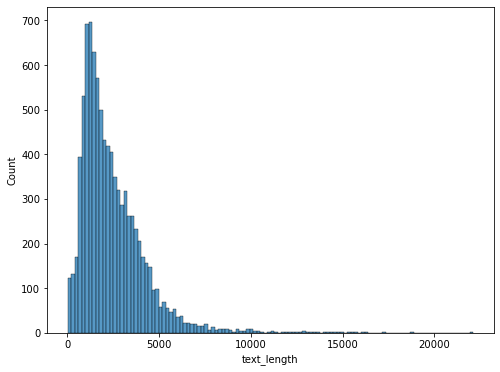

In [114]:
plt.figure(figsize=(8,6))
#df_train.text.str.len().hist()
sns.histplot(data=df_train,x='text_length')

In [126]:
df_train.loc[df_train.text.str.len() <210]

,genre,text,text_length
194,Wirtschaft,Ex-Chef der Bundespolizei solle insbesondere s...,196
219,Web,"Welchen Begriff verwenden Sie, wenn sie Videos...",90
345,International,Lastwagen in die Luft gesprengt. Der Volltext ...,150
418,Wissenschaft,'Ein großangelegtes Forschungsnetzwerk untersu...,204
421,Etat,"600.000 ermittelten mit dem Tatort-Team in ""De...",189
...,...,...,...
8922,Wirtschaft,"'Wo sind die Amerikaner, lautet eine Frage in ...",86
8929,Kultur,Wie gefällt Ihnen das Album? Geben Sie Ihre We...,88
8973,Etat,"Angelique im ORF-2-Hauptabend mit 290.000, ""Zi...",88
9062,Wirtschaft,Die Mercedes-Verkaufszahlen haben in China um ...,192


<AxesSubplot:xlabel='text', ylabel='Count'>

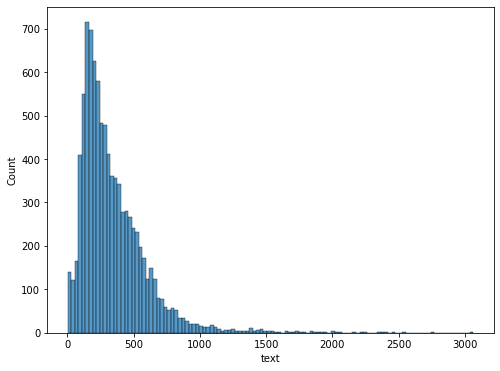

In [128]:
plt.figure(figsize=(8,6))
sns.histplot(x=df_train.text.str.split().str.len())

In [129]:
#Number of words count falls between 100 to 1200

<AxesSubplot:>

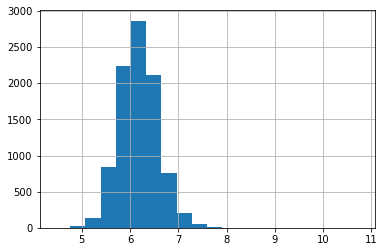

In [140]:
#Find average word length
df_train.text.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist(bins=20)

In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')

In [210]:
stop_words = stopwords.words('german')
stemmer = SnowballStemmer('german')

In [211]:
len(set(stop_words))

232

In [240]:
l1 =['32','23']

In [243]:
" ".join(l1)

'32 23'

In [288]:
def clean_text(text, embedding=False):
    text = re.sub(r'\b\w\b', " ", text, flags=re.I) #Removing all single chracters
    text = re.sub(r"\S*\d\S*", " ", text, flags=re.I) #removing all numbers and alhpanumeric combinations
    if not embedding:
        text = text.translate(str.maketrans("", "", string.punctuation)) #Removing all punctations and keeping for word embeddings
    text = re.sub('\s+', " ", text, flags=re.I).strip() #removing extra spaces 
    word_tokens = word_tokenize(text)
    #words_tokens_lower = [word.lower() for word in word_tokens]
    text = text.lower()
    #print(words_tokens_lower)
    if embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        #words_filtered = [stemmer.stem(word) for word in words_tokens_lower if word not in stop_words]
        text = ' '.join(word for word in text.split() if word not in stop_words)
        words_filtered = [x.lemma_ for x in nlp(text)]
    text_clean = " ".join(words_filtered)
    return text_clean

In [289]:
clean_text('21-Jähriger fällt wohl bis Saisonende aus. tschüss', False)

'fällen wohl saisonende tschüss'

In [290]:
%%time
#Clean text
df_train["clean_text"] = df_train["text"].map(lambda x: clean_text(x, embedding=False) if isinstance(x, str) else x)

CPU times: user 3min 50s, sys: 26.7 s, total: 4min 17s
Wall time: 4min 18s


In [291]:
df_train.loc[0:1,'clean_text'].tolist()

['fällen wohl saisonende wien – rapid wohl saisonende offensivspieler thomas murg verzichten winter ried gekommen erleiden beim heimdebakel admira wacker mödling samstag teilriss innenbandes link knien magnetresonanzuntersuchung donnerstag ergeben murg erhalten schiene operieren dennoch stehen mehrwöchige pause bevor',
 'erfunden bilder filmen verlieren gelten the forbidden room guy maddin evan johnson surrealer ritt magisch labyrinthe früh kinos wien – filmgeschichte friedhof verloren begraben finden zahllos filme der mysteriös abenteuerlich klingend namen kursieren']

In [292]:
df_train.isna().sum()

genre             0
text              0
text_length       0
clean_text        0
clean_text_len    0
dtype: int64

In [293]:
df_train['clean_text_len'] = df_train['clean_text'].str.len()

In [294]:
df_train.head()

,genre,text,text_length,clean_text,clean_text_len
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,448,fällen wohl saisonende wien – rapid wohl saiso...,316
1,Kultur,"'Erfundene Bilder zu Filmen, die als verloren ...",360,erfunden bilder filmen verlieren gelten the fo...,250
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,2116,frischgekürte ceo sundar pichai setzen umgängl...,1548
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",664,putin einigung menge niveau jänner halten mosk...,432
4,Inland,Estland sieht den künftigen österreichischen P...,4393,estland sehen künftig österreichisch präsident...,3134


In [295]:
df_train.to_excel('cleaned_traindata.xlsx')

In [306]:
df_train.shape

(9245, 5)

In [417]:
def get_topngrams(corpus, n):
    vec = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    freqs = zip(vec.get_feature_names(), sum_words.tolist()[0])    
    # sort from largest to smallest
    sorted_list = sorted(freqs, key=lambda x: x[1], reverse=True)
    return sorted_list[:100]

In [389]:
bag_of_words.shape

(9245, 169912)

In [427]:
wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=30, scale=3, random_state=42)

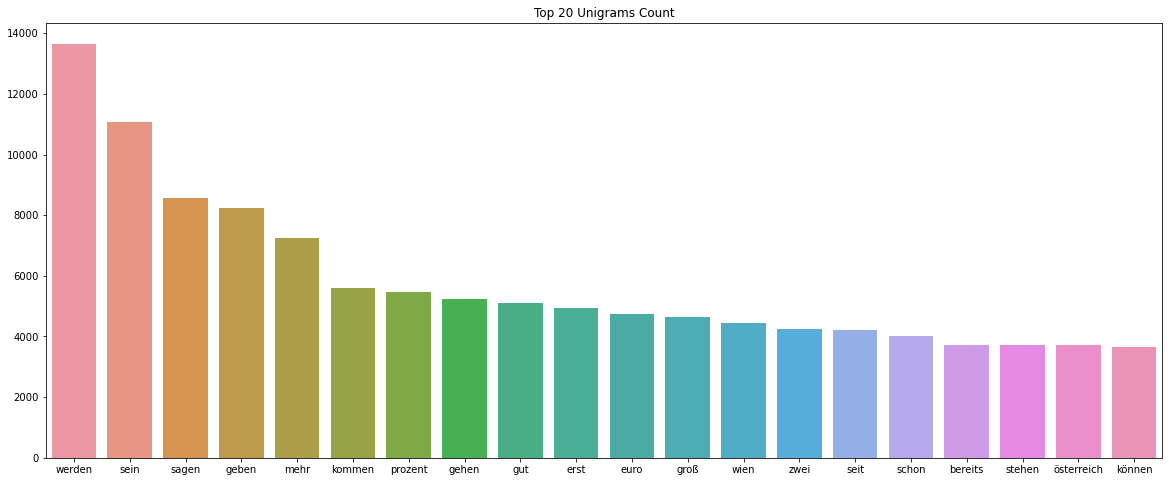

In [488]:
#Plot top unigrams
top_unigrams = get_topngrams(df_train['clean_text'], 1)
x,y = map(list,zip(*top_unigrams[:20]))
plt.figure(figsize=(20,8))
sns.barplot(x=x, y=y)
plt.title('Top 20 Unigrams Count')
plt.show()

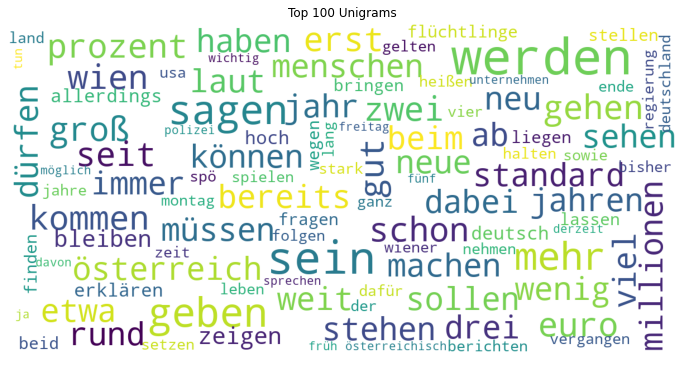

In [448]:
wc = wordcloud.generate_from_frequencies(dict(top_unigrams))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wc)
plt.title('Top 100 Unigrams')
plt.show()

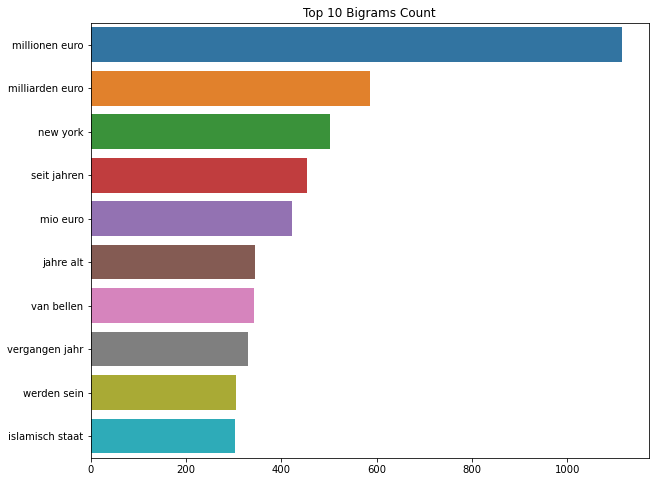

In [439]:
#Plot top unigrams
top_bigrams = get_topngrams(df_train['clean_text'], 2)
x,y = map(list,zip(*top_bigrams[:10]))
plt.figure(figsize=(10,8))
sns.barplot(x=y, y=x)
plt.title('Top 10 Bigrams Count')
plt.show()

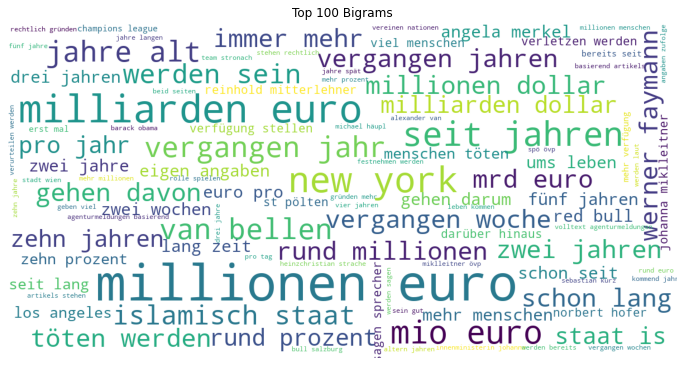

In [449]:
wc = wordcloud.generate_from_frequencies(dict(top_bigrams))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wc)
plt.title('Top 100 Bigrams')
plt.show()

Text(0.5, 1.0, 'Top 10 Trigrams Count')

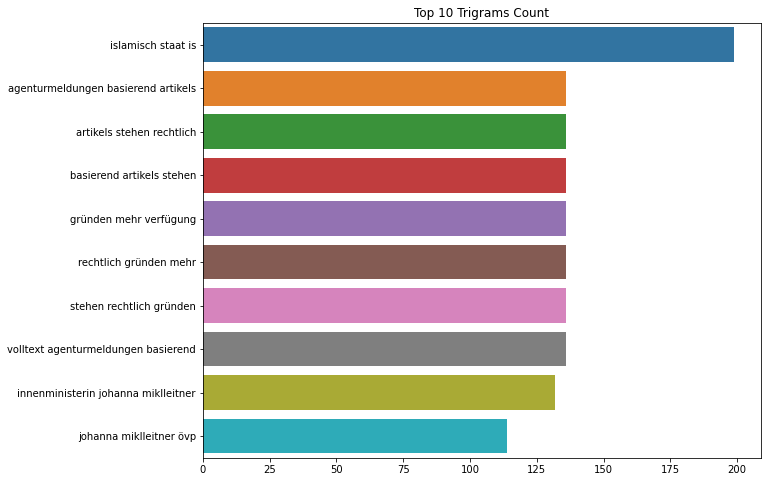

In [442]:
#Plot top unigrams
top_trigrams = get_topngrams(df_train['clean_text'], 3)
x,y = map(list,zip(*top_trigrams[:10]))
plt.figure(figsize=(10,8))
sns.barplot(x=y, y=x)
plt.title('Top 10 Trigrams Count')

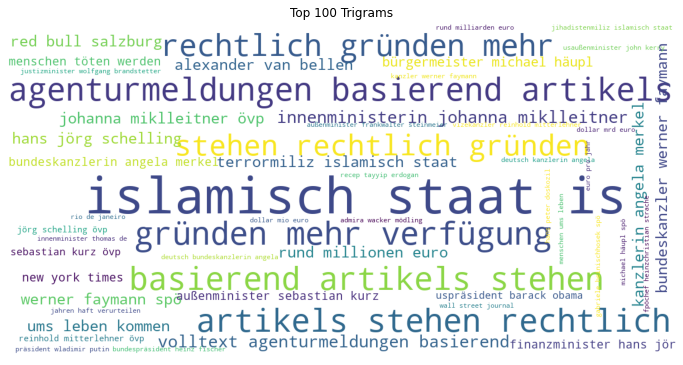

In [450]:
wc = wordcloud.generate_from_frequencies(dict(top_trigrams))
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wc)
plt.title('Top 100 Trigrams')
plt.show()

In [489]:
df_train.clean_text.loc[df_train['genre'] == 'Sport']

0       fällen wohl saisonende wien – rapid wohl saiso...
6       traditionsklub setzen fc utrecht amsterdam – h...
9       abschiedstournee guardiola beginnen beim hsv –...
10      ssc erfolg robert guchers frosinone neu tabell...
13      öfbkapitän planen zeit fußball weiß field goal...
                              ...                        
9138    personell geschwächt rekordmeister bregenz bie...
9158    wind finnland kuusamo – freitag geplant weltcu...
9173    jung österreicher meterhoch luft schleudern – ...
9179    usslalomrekordlerin stürzen super denken night...
9212    ire holen etappe sieg dumoulin wehren arus att...
Name: clean_text, Length: 1081, dtype: object

In [490]:
def get_wordfreq(corpus, n):
    vec = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    freqs = zip(vec.get_feature_names(), sum_words.tolist()[0])
    return freqs

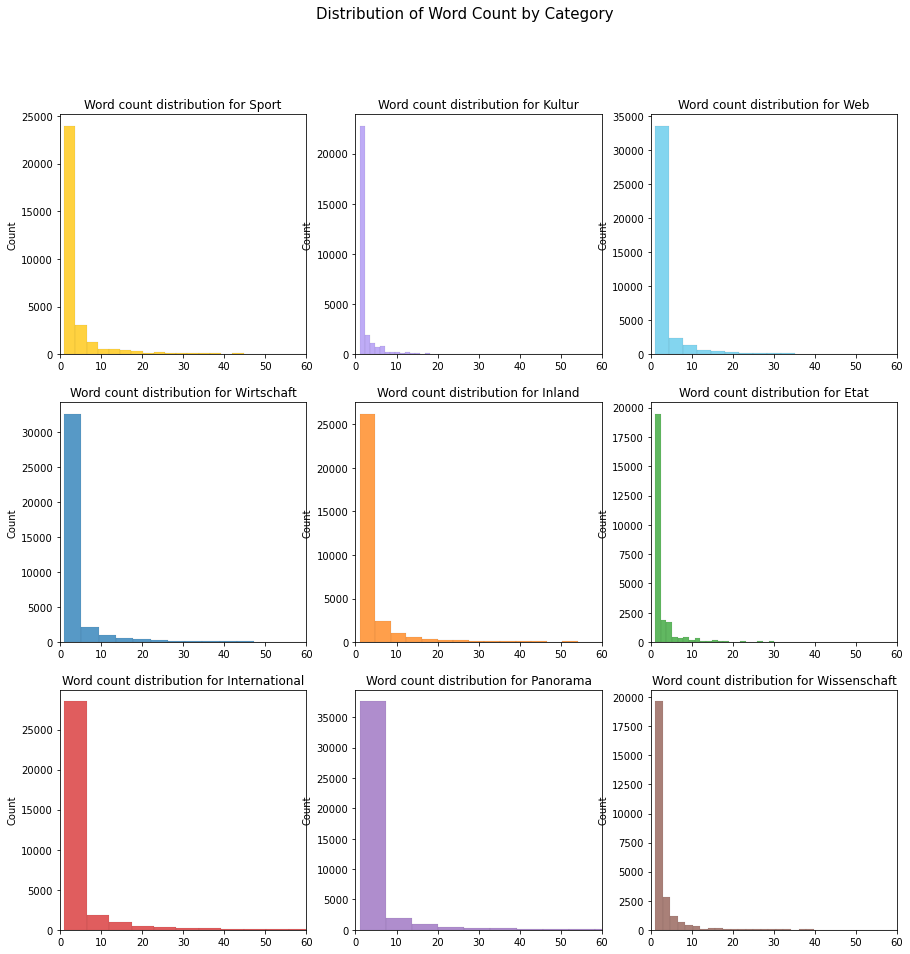

In [524]:
#Distribution of word counts
color = ['#41924f', '#FFC300', '#a98ff3', '#59C7EA', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(15,15))
plt.suptitle(f'Distribution of Word Count by Category', fontsize=15)
for i, topic in enumerate(df_train.genre.unique(), 1):
    plt.subplot(3,3,i)
    word_frequences = get_wordfreq(df_train.clean_text.loc[df_train.genre == topic], 1)
    x,y = map(list,zip(*word_frequences))
    sns.histplot(x=y, bins=500, color=color[i])
    plt.xlim(0, 60)
    plt.title(f'Word count distribution for {topic}')
plt.show()

In [476]:
def generate_wordcloud(data,title, i):
    wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=30, scale=3, random_state=42)
    plt.subplot(5, 2, i)
    wc = wordcloud.generate(data)
    #plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'{title} class top words',fontsize=13)

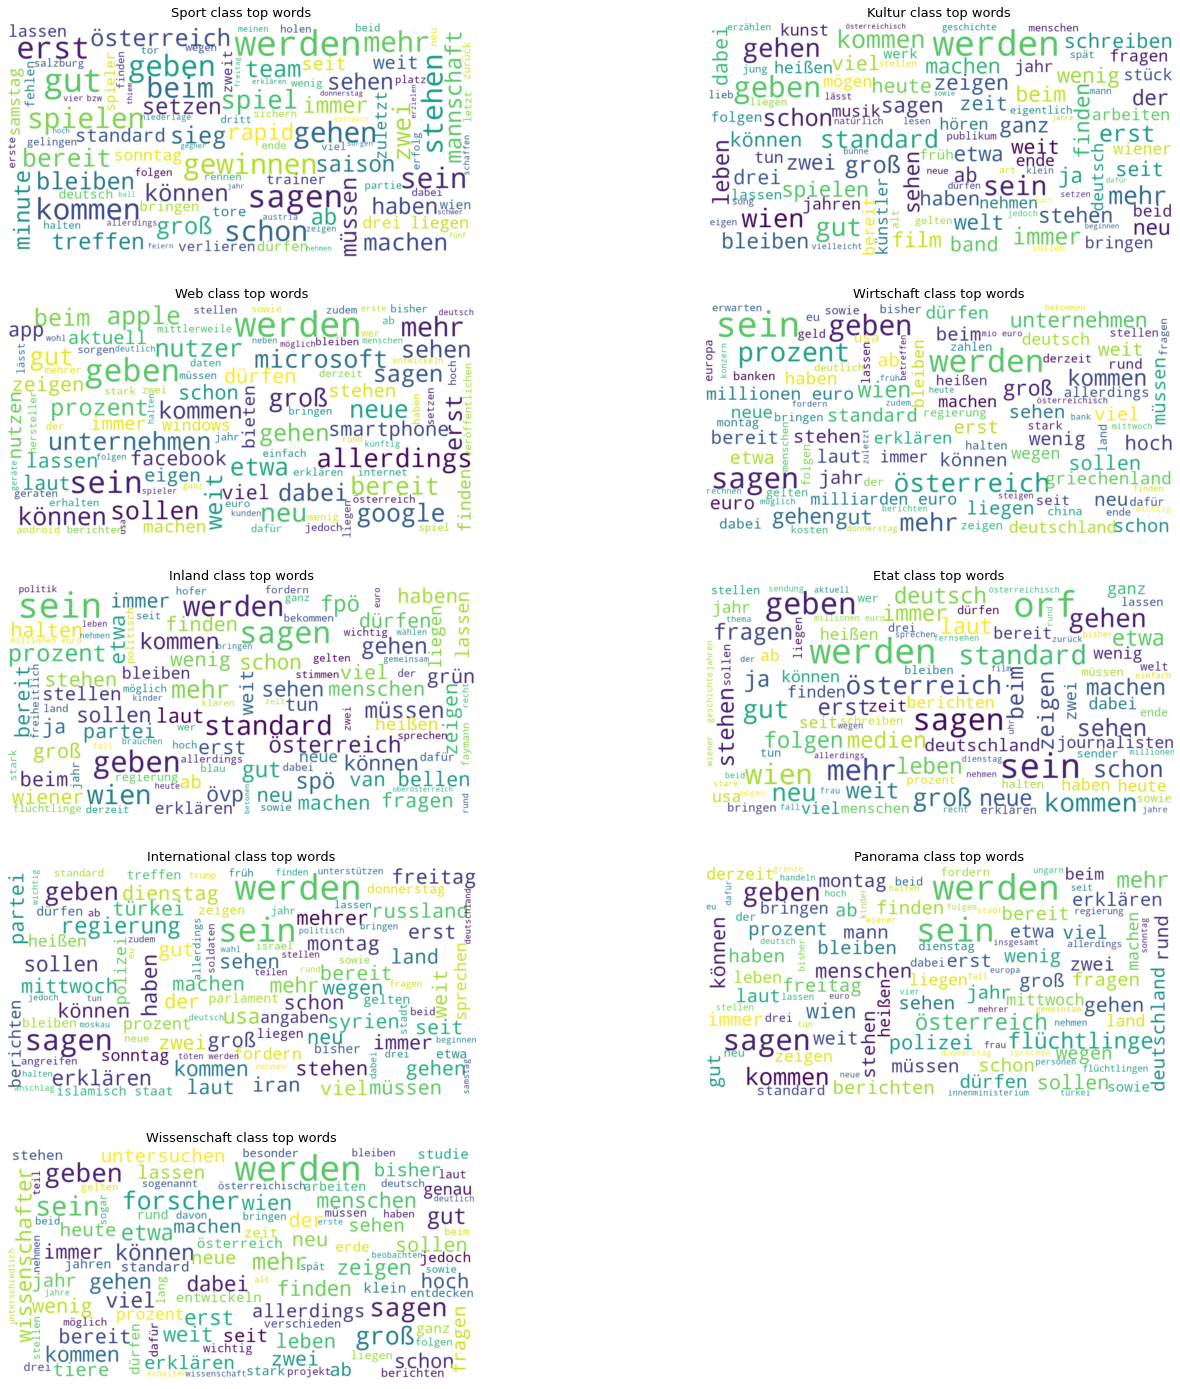

In [483]:
plt.figure(figsize=(25, 25))
for i, topic in enumerate(df_train.genre.unique(), 1):
    data = " ".join(df_train.clean_text.loc[df_train.genre == topic].tolist())
    generate_wordcloud(data, topic, i)
plt.subplots_adjust(wspace=0.0, hspace=0.2)
plt.show()

In [547]:
tf_idf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), norm="l2", max_df=0.5, min_df=2) # max_df=0.5, min_df=2

In [548]:
tf_idf_vectorizer.fit(df_train["clean_text"])

TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2))

In [549]:
tf_idf_vectorizer.vocabulary_

{'fällen': 57811,
 'wohl': 189055,
 'saisonende': 138180,
 'wien': 186533,
 'rapid': 130748,
 'offensivspieler': 119873,
 'thomas': 163353,
 'murg': 111701,
 'verzichten': 176303,
 'winter': 187801,
 'ried': 134663,
 'gekommen': 62141,
 'erleiden': 44229,
 'beim': 16207,
 'admira': 2024,
 'wacker': 180080,
 'mödling': 112380,
 'samstag': 138590,
 'link': 100017,
 'knien': 89136,
 'donnerstag': 34940,
 'ergeben': 43165,
 'erhalten': 43361,
 'schiene': 140030,
 'operieren': 120618,
 'dennoch': 31670,
 'stehen': 156074,
 'mehrwöchige': 106095,
 'pause': 123101,
 'bevor': 20856,
 'wohl saisonende': 189138,
 'wien rapid': 186940,
 'thomas murg': 163383,
 'erleiden beim': 44230,
 'admira wacker': 2042,
 'wacker mödling': 180082,
 'mödling samstag': 112384,
 'link knien': 100031,
 'dennoch stehen': 31712,
 'erfunden': 43122,
 'bilder': 21882,
 'filmen': 51850,
 'verlieren': 174218,
 'gelten': 62551,
 'the': 162960,
 'forbidden': 54331,
 'room': 135244,
 'guy': 70727,
 'evan': 48519,
 'johnson

In [550]:
X_train, X_test, y_train, y_test = train_test_split(df_train.clean_text, df_train.genre, test_size=0.2, random_state=42)

In [551]:
X_train_vec = tf_idf_vectorizer.transform(X_train)
X_test_vec = tf_idf_vectorizer.transform(X_test)

In [552]:
X_train_vec.get_shape() #1504931 #199115

(7396, 199115)

In [535]:
X_train_vec[3:4].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [553]:
# Feature Matrix
features = pd.DataFrame(X_train_vec[3:4].toarray(), columns=tf_idf_vectorizer.get_feature_names())

In [554]:
features.head()

,aa,aaa,aachen,aachen entfernen,aak,aalborg,aale,aalen,aalglatt,aamodt,...,übungen,üppig,čapljak,şenol,şenol akkılıç,šefic,šentilj,šešelj,škoda,žižek
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [582]:
def top_tfidf_features(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [583]:
def top_features_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_features(row, features, top_n)

In [584]:
top_features_in_doc(X_train_vec, tf_idf_vectorizer.get_feature_names(), 1)

,feature,tfidf
0,bewerbungen,0.267697
1,regisseurin,0.265600
2,corinne,0.240574
3,dschungel,0.204216
4,theater,0.166082
5,dschungel wien,0.165659
6,jung publikum,0.152947
7,kulturstadtrat,0.143579
8,wien laut,0.140236
9,mailathpokorny,0.138768


In [589]:
def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    #print(tfidf_means)
    return top_tfidf_features(tfidf_means, features, top_n)

In [569]:
#Most important words accross whole corpus
top_mean_features(X_train_vec, tf_idf_vectorizer.get_feature_names())

[1.41211198e-05 2.81100245e-05 3.14911762e-05 ... 9.04926651e-05
 0.00000000e+00 1.35238507e-05]


,feature,tfidf
0,prozent,0.007463
1,standard,0.004880
2,flüchtlinge,0.004001
3,euro,0.003883
4,apple,0.003204
5,gründen mehr,0.003008
6,basierend artikels,0.003008
7,artikels stehen,0.003008
8,volltext,0.003008
9,agenturmeldungen basierend,0.003008


## Get important words for each class

In [590]:
def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [593]:
top_class_featus_df = top_features_by_class(X_train_vec, y_train, tf_idf_vectorizer.get_feature_names())

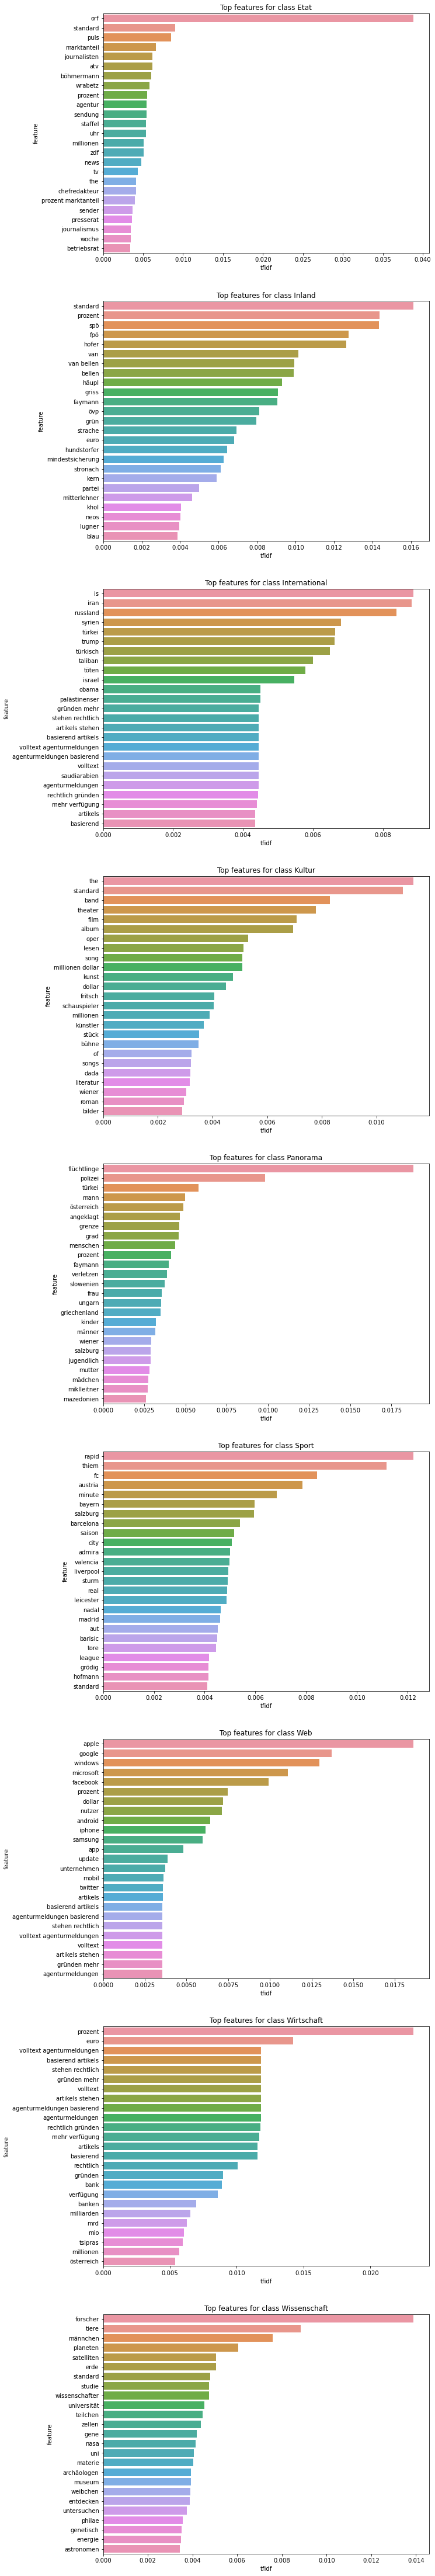

In [637]:
plt.figure(figsize=(10,80))
for i, df in enumerate(top_class_featus_df, 1):
    #print(df)
    plt.subplot(9,1,i)
    sns.barplot(data=df, y='feature', x='tfidf')
    plt.title(f'Top features for class {df.label}')
plt.show()

In [718]:
selectk_best = SelectKBest(score_func=chi2, k=120000)

In [719]:
X_train_k_select = selectk_best.fit(X_train_vec,y_train)

In [720]:
X_train_k_select_vec = X_train_k_select.transform(X_train_vec)

In [721]:
X_test_k_select_vec = X_train_k_select.transform(X_test_vec)

In [722]:
X_train_k_select_vec.shape

(7396, 120000)

In [660]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:03:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


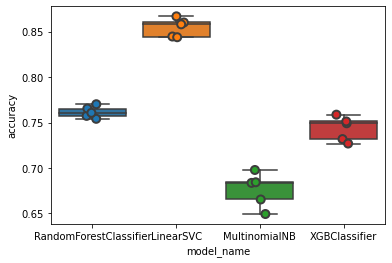

In [731]:
models = [
    RandomForestClassifier(n_estimators=1500, random_state=42, min_samples_split=3, min_samples_leaf=2),
    LinearSVC(),
    XGBClassifier(learning_rate =0.07,n_estimators=100),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_k_select_vec, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


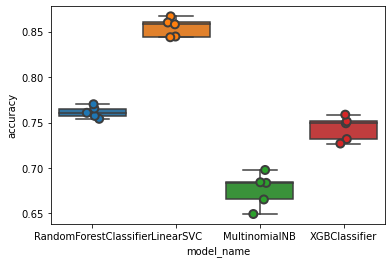

In [732]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [664]:
rf_clf = RandomForestClassifier(n_estimators=1500, random_state=42, min_samples_split=3, min_samples_leaf=2, )
rf_clf.fit(X_train_k_select_vec, y_train)
print_score(rf_clf, X_train_k_select_vec, y_train, X_test_k_select_vec, y_test, train=True)
print_score(rf_clf, X_train_k_select_vec, y_train, X_test_k_select_vec, y_test, train=False)

Train Result:
Accuracy Score: 97.43%
_______________________________________________
CLASSIFICATION REPORT:
                 Etat      Inland  International      Kultur     Panorama  \
precision    0.997758    0.986339       0.971028    0.994709     0.972108   
recall       0.913758    0.983651       0.967412    0.976623     0.985857   
f1-score     0.953912    0.984993       0.969216    0.985583     0.978934   
support    487.000000  734.000000    1074.000000  385.000000  1202.000000   

                Sport          Web   Wirtschaft  Wissenschaft  accuracy  \
precision    0.997677     0.967042     0.938389      0.989770   0.97431   
recall       0.996520     0.970161     0.984095      0.953202   0.97431   
f1-score     0.997098     0.968599     0.960699      0.971142   0.97431   
support    862.000000  1240.000000  1006.000000    406.000000   0.97431   

             macro avg  weighted avg  
precision     0.979424      0.974743  
recall        0.970142      0.974310  
f1-score     

In [725]:
xgb_clf = XGBClassifier(n_estimators=100, enable_categorical=True) #n_jobs=4,
xgb_clf.fit(X_train_k_select_vec, y_train)

print_score(xgb_clf, X_train_k_select_vec, y_train, X_test_k_select_vec, y_test, train=True)
print_score(xgb_clf, X_train_k_select_vec, y_train, X_test_k_select_vec, y_test, train=False)

/Users/raghu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:35:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Result:
Accuracy Score: 99.97%
_______________________________________________
CLASSIFICATION REPORT:
            Etat  Inland  International  Kultur     Panorama  Sport     Web  \
precision    1.0     1.0       0.999070     1.0     1.000000    1.0     1.0   
recall       1.0     1.0       1.000000     1.0     0.998336    1.0     1.0   
f1

In [723]:
lsvc_clf = LinearSVC(C=1.0) #n_jobs=4,
lsvc_clf.fit(X_train_k_select_vec, y_train)

print_score(lsvc_clf, X_train_k_select_vec, y_train, X_test_k_select_vec, y_test, train=True)
print_score(lsvc_clf, X_train_k_select_vec, y_train, X_test_k_select_vec, y_test, train=False)

Train Result:
Accuracy Score: 99.89%
_______________________________________________
CLASSIFICATION REPORT:
                 Etat  Inland  International  Kultur     Panorama  Sport  \
precision    1.000000     1.0       1.000000     1.0     0.999167    1.0   
recall       0.997947     1.0       0.998138     1.0     0.998336    1.0   
f1-score     0.998972     1.0       0.999068     1.0     0.998752    1.0   
support    487.000000   734.0    1074.000000   385.0  1202.000000  862.0   

                   Web   Wirtschaft  Wissenschaft  accuracy    macro avg  \
precision     0.998387     0.996036      0.997543  0.998918     0.999015   
recall        0.998387     0.999006      1.000000  0.998918     0.999090   
f1-score      0.998387     0.997519      0.998770  0.998918     0.999052   
support    1240.000000  1006.000000    406.000000  0.998918  7396.000000   

           weighted avg  
precision      0.998920  
recall         0.998918  
f1-score       0.998919  
support     7396.000000  


In [747]:
lscv_pipiline = make_pipeline(TfidfVectorizer(analyzer='word', ngram_range=(1, 2), norm="l2", max_df=0.5, min_df=2), 
             SelectKBest(chi2, k=90000),
             LinearSVC(C=1.0)).fit(X_train, y_train)

In [748]:
print_score(lscv_pipiline, X_train, y_train, X_test, y_test, train=True)
print_score(lscv_pipiline, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.86%
_______________________________________________
CLASSIFICATION REPORT:
                 Etat  Inland  International  Kultur     Panorama  Sport  \
precision    1.000000     1.0       1.000000     1.0     0.999167    1.0   
recall       0.997947     1.0       0.998138     1.0     0.997504    1.0   
f1-score     0.998972     1.0       0.999068     1.0     0.998335    1.0   
support    487.000000   734.0    1074.000000   385.0  1202.000000  862.0   

                   Web   Wirtschaft  Wissenschaft  accuracy    macro avg  \
precision     0.998386     0.994065      0.997543  0.998648     0.998796   
recall        0.997581     0.999006      1.000000  0.998648     0.998908   
f1-score      0.997983     0.996529      0.998770  0.998648     0.998851   
support    1240.000000  1006.000000    406.000000  0.998648  7396.000000   

           weighted avg  
precision      0.998652  
recall         0.998648  
f1-score       0.998649  
support     7396.000000  


In [772]:
df_test = pd.read_csv('test.csv', delimiter=';')

In [773]:
df_test.head()

,genre,text
0,Wirtschaft,"'Die Gewerkschaft GPA-djp lanciert den ""All-in..."
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...
2,Web,'Neues Video von Designern macht im Netz die R...
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...
4,International,Aufständische verwendeten Chemikalie bei Gefec...


In [774]:
df_test["clean_text"] = df_test["text"].map(lambda x: clean_text(x, embedding=False) if isinstance(x, str) else x)

In [776]:
df_test.head()

,genre,text,clean_text
0,Wirtschaft,"'Die Gewerkschaft GPA-djp lanciert den ""All-in...",gewerkschaft gpadjp lanciert allinrechner find...
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...,franzosen verteidigen führung – kritisch stimm...
2,Web,'Neues Video von Designern macht im Netz die R...,neu video designern machen netz runden – schla...
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...,brasilianer vier spiele pausieren – entscheidu...
4,International,Aufständische verwendeten Chemikalie bei Gefec...,aufständisch verwenden chemikalie gefechten au...


In [777]:
print_score(lscv_pipiline, X_train, y_train, df_test["clean_text"], df_test["genre"], train=False)

Test Result:
Accuracy Score: 85.99%
_______________________________________________
CLASSIFICATION REPORT:
                Etat      Inland  International     Kultur    Panorama  \
precision   0.924528    0.851064       0.884892   0.851852    0.782609   
recall      0.731343    0.784314       0.814570   0.851852    0.857143   
f1-score    0.816667    0.816327       0.848276   0.851852    0.818182   
support    67.000000  102.000000     151.000000  54.000000  168.000000   

                Sport         Web  Wirtschaft  Wissenschaft  accuracy  \
precision    0.975207    0.913043    0.770186      0.868852  0.859922   
recall       0.983333    0.875000    0.879433      0.929825  0.859922   
f1-score     0.979253    0.893617    0.821192      0.898305  0.859922   
support    120.000000  168.000000  141.000000     57.000000  0.859922   

             macro avg  weighted avg  
precision     0.869137      0.864189  
recall        0.856312      0.859922  
f1-score      0.860408      0.860074  


In [778]:
import joblib

In [779]:
joblib.dump(lscv_pipiline, 'linearsvm_model_pipeline.bz2')

['linearsvm_model_pipeline.bz2']

In [786]:
y_predicted = lscv_pipiline.predict(['Jähriger fällt wohl bis Saisonende aus. Wie.'])

In [787]:
y_predicted[0]

'Sport'

In [780]:
import sys

In [782]:
sys.version

3.8.8


In [272]:
import spacy
nlp = spacy.load('de_core_news_sm')

mails=['21-Jähriger fällt wohl bis Saisonende aus. tschüss','Hallo. Ich spielte am frühen Morgen und ging dann zu einem Freund. Auf Wiedersehen', 'Guten Tag Ich mochte Bälle und will etwas kaufen. Tschüss']

mails_lemma = []

for mail in mails:
    result = ' '.join([x.lemma_ for x in nlp(mail)])
    mails_lemma.append(result)
print(mails_lemma)

['21-Jähriger fällen wohl bis Saisonende aus . tschüss', 'Hallo . Ich spielen am früh Morgen und gehen dann zu einer Freund . Auf Wiedersehen', 'Guten Tag Ich mögen Ball und wollen etwas kaufen . Tschüss']


In [262]:
#!pip install spacy
#!python -m spacy download de

In [285]:
[x.tag_ for x in nlp(mail)]

['ADJA',
 'NN',
 'PPER',
 'VVFIN',
 'NN',
 'KON',
 'VMFIN',
 'PIS',
 'VVINF',
 '$.',
 'NE']

In [286]:
[x.pos_ for x in nlp(mail)]

['ADJ',
 'NOUN',
 'PRON',
 'VERB',
 'NOUN',
 'CCONJ',
 'AUX',
 'PRON',
 'VERB',
 'PUNCT',
 'PROPN']

In [788]:
import sklearn

In [789]:
sklearn.__version__

'0.24.1'